In [4]:
import pandas as pd
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from matplotlib import rc
import seaborn as sns
import statsmodels.formula.api as smf
from scipy.stats import gaussian_kde
import pickle
from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneGroupOut
import os
from tqdm import tqdm

In [5]:
"""
Define figure parameters for RSE
"""
# image widths (inches from cm) for Elsevier
one_col = 9 / 2.54
half_pg = 14 / 2.54
full_pg = 19 / 2.54

# font sizes
font_xsml = 6
font_sml = 8
font_med = 10
font_lg = 12
font_xlg = 14

# save all figures?
save_all_figs = True

In [14]:
"""
Define input and output files and directories
"""
# output directories
outDIR_figs = './results/figures/'
outDIR_tables = './results/tables/'

# input directories and files
inDIR = '../data/training/'
inFILE = 'vor_2013_2022_cln_2023_04_26_hls_idxs_manual_combine.csv'

# input models
lreg_all = pickle.load(open("../models/biomass/CPER_HLS_to_VOR_biomass_model_lr_20230707.pk", 'rb'))

# original names for input variables
var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}

In [8]:
"""
Define necessary functions
"""


def abline(slope, intercept, color='black', linewidth=None):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '-', c=color, linewidth=linewidth)


In [21]:
"""
Preprocess data
"""
# extracted plot data
df_vor = pd.read_csv(os.path.join(inDIR, inFILE))

# set date structure
df_vor['Date'] = pd.to_datetime(df_vor['Date'])

# rename columns
df_vor = df_vor.rename(columns=var_dict)

# predict biomass from saved model
df_vor['bm_log'] = np.log(df_vor['Biomass_kg_ha'])
df_vor['bm_pred_lr_orig'] = lreg_all.predict(df_vor)
df_vor['bm_pred_lr'] = np.exp(df_vor['bm_pred_lr_orig'])

# get residuals
df_vor['bm_resid_orig'] = df_vor['bm_pred_lr_orig'] - df_vor['bm_log']
df_vor['bm_resid'] = df_vor['bm_pred_lr'] - df_vor['Biomass_kg_ha']

# get formulas from input models
lr_form_fnl = re.sub('Intercept \+ ', 'np.log(bm) ~ ', ' + '.join(lreg_all.params.index))

# subset june and october data
df_vor_jo = df_vor[df_vor['Season'].isin(['June', 'October'])].copy()

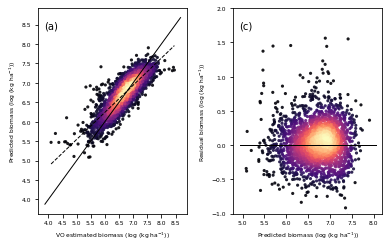

In [31]:
"""
Figure (Supplement): Plot log-scale residuals vs. log-scale predictions to check for heteroscedasticity
"""
# calculate density in plot space for plot colorizations
xy_bm = np.vstack([df_vor_jo['bm_pred_lr_orig'],
                        df_vor_jo['bm_log']])
df_vor_jo['z_bm_log'] = gaussian_kde(xy_bm)(xy_bm)

xy_bm_resid = np.vstack([df_vor_jo['bm_resid_orig'],
                              np.log(df_vor_jo['bm_pred_lr_orig'])])
df_vor_jo['z_resid'] = gaussian_kde(xy_bm_resid)(xy_bm_resid)

# create and save figure
fig = plt.figure(figsize=(half_pg, one_col))
ax1 = fig.add_subplot(1, 2, 1)
sns.scatterplot(x='bm_log', y='bm_pred_lr_orig', data=df_vor_jo, hue='z_bm_log', palette='magma',
                linewidth=0, alpha=0.9, legend=False, ax=ax1, s=10)
abline(1, 0, linewidth=1)
#fit = np.polyfit(df_vor_jo.bm_log, df_vor_jo.bm_pred_lr_orig, deg=1)
fit = smf.ols('bm_pred_lr_orig ~ bm_log', df_vor_jo).fit()
if fit.f_pvalue < 0.05:
    ax1.plot(df_vor_jo['bm_log'].sort_values(), fit.predict(df_vor_jo.sort_values('bm_log')),
             linestyle='dashed', color='black', linewidth=1)
ax1.set_xlabel('$\mathregular{VO\ estimated\ biomass\ (log\ (kg\ ha^{-1}))}$', fontsize=font_xsml)
ax1.set_ylabel('$\mathregular{Predicted\ biomass\ (log\ (kg\ ha^{-1}))}$', fontsize=font_xsml)
ax1.tick_params(axis='both', which='major', labelsize=font_xsml)
ax1.xaxis.set_major_locator(mtick.MultipleLocator(0.5))
ax1.yaxis.set_major_locator(mtick.MultipleLocator(0.5))
ax1.text(x=0.04, y=0.9, s='(a)', transform=ax1.transAxes, size=font_med)

ax2 = fig.add_subplot(1, 2, 2)
fit_resid = smf.ols('bm_resid_orig ~ bm_pred_lr_orig + I(bm_pred_lr_orig**2)', df_vor_jo).fit()
sns.scatterplot(x='bm_pred_lr_orig', y='bm_resid_orig', data=df_vor_jo, hue='z_resid', palette='magma',
                linewidth=0, alpha=0.9, legend=False, ax=ax2, s=10)
abline(0, 0, linewidth=1)
if fit_resid.f_pvalue < 0.05:
    ax2.plot(df_vor_jo['bm_pred_lr_orig'].sort_values(),
             fit_resid.predict(df_vor_jo.sort_values('bm_pred_lr_orig')),
             linestyle='dashed', color='black', linewidth=1)
ax2.set_xlabel('$\mathregular{Predicted\ biomass\ (log\ (kg\ ha^{-1}))}$', fontsize=font_xsml)
ax2.set_ylabel('$\mathregular{Residual\ biomass\ (log\ (kg\ ha^{-1}))}$', fontsize=font_xsml)
ax2.tick_params(axis='both', which='major', labelsize=font_xsml)
ax2.xaxis.set_major_locator(mtick.MultipleLocator(0.5))
ax2.yaxis.set_major_locator(mtick.MultipleLocator(0.5))
ax2.set_ylim((-1.0, 2.0))
ax2.text(x=0.04, y=0.9, s='(c)', transform=ax2.transAxes, size=font_med)

plt.tight_layout(h_pad=1.5, w_pad=1.0)
if save_all_figs:
    plt.savefig(os.path.join(outDIR_figs, 'supplemental/', 'Pred_vs_obs_log_biomass_fnl_model.png'), dpi=300,
                bbox_inches='tight', pad_inches=0.2)
#plt.close()

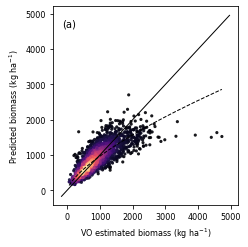

In [36]:
"""
Figure (Supplement): Plot Predicted vs. Observed biomass
"""
# calculate density in plot space for plot colorization
xy_bm = np.vstack([df_vor_jo['bm_pred_lr'],
                        df_vor_jo['Biomass_kg_ha']])
df_vor_jo['z_bm'] = gaussian_kde(xy_bm)(xy_bm)

# create and save figure
fig = plt.figure(figsize=(one_col, one_col))
ax1 = fig.add_subplot(1, 1, 1)
sns.scatterplot(x='Biomass_kg_ha', y='bm_pred_lr', data=df_vor_jo, hue='z_bm', palette='magma',
                linewidth=0, alpha=0.9, legend=False, ax=ax1, s=10)
abline(1, 0, linewidth=1)
if fit.f_pvalue < 0.05:
    ax1.plot(np.exp(df_vor_jo['bm_log'].sort_values()), np.exp(fit.predict(df_vor_jo.sort_values('bm_log'))),
             linestyle='dashed', color='black', linewidth=1)
ax1.set_xlabel('$\mathregular{VO\ estimated\ biomass\ (kg\ ha^{-1})}$', fontsize=font_sml)
ax1.set_ylabel('$\mathregular{Predicted\ biomass\ (kg\ ha^{-1})}$', fontsize=font_sml)
ax1.text(x=0.05, y=0.9, s='(a)', transform=ax1.transAxes, size=font_med)
ax1.tick_params(axis='both', which='major', labelsize=font_sml)
ax1.xaxis.set_major_locator(mtick.MultipleLocator(1000))
ax1.yaxis.set_major_locator(mtick.MultipleLocator(1000))

plt.tight_layout(w_pad=1.0)
if save_all_figs:
    plt.savefig(os.path.join(outDIR_figs, 'supplemental/', 'Pred_vs_obs_kg_biomass_fnl_model.png'), dpi=300, bbox_inches='tight', pad_inches=0.2)
#plt.close()


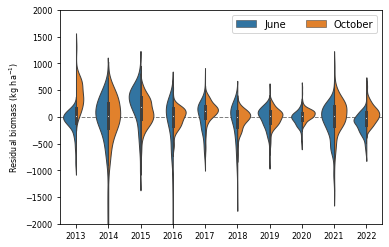

In [42]:
"""
Figure 3: Plot residuals by Year and Season
"""
fig = plt.figure(figsize=(half_pg, one_col))
ax1 = fig.add_subplot(1, 1, 1)
vplot1 = sns.violinplot(x='Year', y='bm_resid', hue='Season', data=df_vor_jo,
                        zorder=2, split=True, cut=2, ax=ax1, linewidth=1.0)
ax1.axhline(0, 0, 1, c='grey', zorder=-1, linestyle='--', linewidth=1.0)
ax1.set_ylabel('$\mathregular{Residual\ biomass\ (kg\ ha^{-1})}$', fontsize=font_sml)
ax1.set_xlabel('')
ax1.set_ylim((-2000, 2000))
ax1.legend(loc='upper right', ncol=2, fontsize=font_med)
#ax1.text(x=0.025, y=0.90, s='(a)', transform=ax1.transAxes, size=font_med)
ax1.tick_params(axis='both', which='major', labelsize=font_sml)
ax1.yaxis.set_major_locator(mtick.MultipleLocator(500))

plt.tight_layout(h_pad=1.0)
if save_all_figs:
    plt.savefig(os.path.join(outDIR_figs, 'biomass_residual_by_year_season.png'), dpi=300, bbox_inches='tight', pad_inches=0.2)
#plt.close()


In [48]:
"""
Plot bootstrapped percent error based on the number of years used to train the model
"""
# define line styles for each year based on weather and productivity
lines_yrs_dict = {2013: '-.',
                  2014: '--', 2015: '--',
                  2016: '-', 2017: '-', 2018: '-', 2019: '-', 2021: '-',
                  2020: ':',
                  2022: ':'}

# using final models, predict biomass for unseen years using k-fold bootstrapping across all combinations of years
log_xfrm = True
wtd = False
poly = False
scale_vars = False
mod_logo = LeaveOneGroupOut()

df_results_yrs = pd.DataFrame(columns=['formula', 'numb_yrs', 'yr_train', 'yr_test',
                                       'R2', 'AIC', 'mae_kg', 'mae_pct'])
for yr_n in tqdm(range(2, 1 + len(df_vor_jo['Year'].unique()))):
    for yr_combo in itertools.combinations(df_vor_jo['Year'].unique(), yr_n):
        #print(yr_combo)
        df_vor_jo_yr_sub = df_vor_jo[df_vor_jo['Year'].isin(yr_combo)]
        df_vor_jo_yr_sub = df_vor_jo_yr_sub.rename(columns={'Biomass_kg_ha': 'bm'})
        rmse_kg_tmp = []
        mpe_tmp = []
        rmse_kg_low_tmp = []
        mean_kg_low_tmp = []
        mpe_low_tmp = []
        for train_index, test_index in mod_logo.split(df_vor_jo_yr_sub, groups=df_vor_jo_yr_sub['Year']):
            df_train = df_vor_jo_yr_sub.iloc[train_index]
            df_test = df_vor_jo_yr_sub.iloc[test_index]
            if wtd:
                lreg_k_tmp = smf.wls(formula=lr_form_fnl, data=df_train,
                                     weights=1 / df_train['bm']).fit()
            else:
                lreg_k_tmp = smf.ols(formula=lr_form_fnl, data=df_train).fit()
            if log_xfrm:
                see_k_tmp = np.sqrt(np.sum((np.log(df_vor_jo_yr_sub['bm'].iloc[train_index]) -
                                            lreg_k_tmp.predict(df_vor_jo_yr_sub.iloc[train_index])) ** 2) /
                                    (len(train_index) - len(lreg_k_tmp.params)))
                cf_k_tmp = np.exp(see_k_tmp ** 2 / 2)  # correction factor from Sprugel 1983

                pred_tmp = np.exp(lreg_k_tmp.predict(df_test))  # * cf_k_tmp
            else:
                pred_tmp = lreg_k_tmp.predict(df_test)
            low_idx = df_test['bm'] < 700
            mae_kg_tmp = np.nanmean(np.abs(pred_tmp - df_test['bm']))
            mae_pct_tmp = mae_kg_tmp / df_test['bm'].mean()
            df_results_yrs_tmp = pd.DataFrame(dict(formula=[lr_form_fnl],
                                                   numb_yrs=[yr_n - 1],
                                                   yr_train=[df_train['Year'].unique()],
                                                   yr_test=str(df_test['Year'].unique()[0]),
                                                   R2=round(lreg_k_tmp.rsquared, 2),
                                                   AIC=round(lreg_k_tmp.aic, 2),
                                                   mae_kg=round(mae_kg_tmp, 2),
                                                   mae_pct=round(mae_pct_tmp, 2)))
            df_results_yrs = pd.concat([df_results_yrs, df_results_yrs_tmp])

(2013, 2014)
(2013, 2015)
(2013, 2016)
(2013, 2017)
(2013, 2018)
(2013, 2019)
(2013, 2020)
(2013, 2021)
(2013, 2022)
(2014, 2015)
(2014, 2016)
(2014, 2017)
(2014, 2018)
(2014, 2019)
(2014, 2020)
(2014, 2021)
(2014, 2022)
(2015, 2016)
(2015, 2017)
(2015, 2018)
(2015, 2019)
(2015, 2020)
(2015, 2021)
(2015, 2022)
(2016, 2017)
(2016, 2018)
(2016, 2019)
(2016, 2020)
(2016, 2021)
(2016, 2022)
(2017, 2018)
(2017, 2019)
(2017, 2020)
(2017, 2021)
(2017, 2022)
(2018, 2019)
(2018, 2020)
(2018, 2021)
(2018, 2022)
(2019, 2020)
(2019, 2021)
(2019, 2022)
(2020, 2021)
(2020, 2022)
(2021, 2022)
(2013, 2014, 2015)
(2013, 2014, 2016)
(2013, 2014, 2017)
(2013, 2014, 2018)
(2013, 2014, 2019)
(2013, 2014, 2020)
(2013, 2014, 2021)
(2013, 2014, 2022)
(2013, 2015, 2016)
(2013, 2015, 2017)
(2013, 2015, 2018)
(2013, 2015, 2019)
(2013, 2015, 2020)
(2013, 2015, 2021)
(2013, 2015, 2022)
(2013, 2016, 2017)
(2013, 2016, 2018)
(2013, 2016, 2019)
(2013, 2016, 2020)
(2013, 2016, 2021)
(2013, 2016, 2022)
(2013, 2017, 201

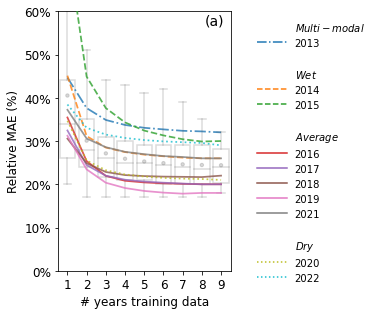

In [63]:
# create and save figure
pal = 'tab10'
col_pal = sns.color_palette(pal,
                            n_colors=len(df_results_yrs.yr_test.unique()))
fig = plt.figure(figsize=(full_pg * 0.7, full_pg * 0.6))
ax1 = fig.add_subplot(1, 1, 1)
sns.boxplot(x='numb_yrs', y='mae_pct', color='grey', data=df_results_yrs, ax=ax1,
            boxprops=dict(alpha=0.2, facecolor='white'), whiskerprops=dict(alpha=0.2), medianprops=dict(alpha=0.2),
            capprops=dict(alpha=0.2), flierprops=dict(alpha=0.2),
            showfliers=False, zorder=2)
yr_plt3 = sns.pointplot(x='numb_yrs', y='mae_pct',
                        data=df_results_yrs, hue='yr_test', palette=col_pal,
                        hue_order=['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2021', '2020', '2022'],
                        ax=ax1, linestyles=list(lines_yrs_dict.values()), errorbar=None, estimator=np.mean)
plt.setp(yr_plt3.collections, sizes=[0])
plt.setp(yr_plt3.lines[-len(df_results_yrs.yr_test.unique()):], linewidth=1.75,
         alpha=0.80)
avg_plt3 = sns.pointplot(x='numb_yrs', y='mae_pct', data=df_results_yrs,
                         ax=ax1, color='grey', errorbar=None, linestyles='', scale=0.5)
plt.setp(avg_plt3.collections[-1], alpha=0.30)
plt.setp(avg_plt3.lines[-1], alpha=0.30)
ax1.set_ylim((0, 0.6))
ax1.set_xlabel('# years training data', fontsize=font_lg)
ax1.set_ylabel('Relative MAE (%)', fontsize=font_lg)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax1.tick_params(axis='both', which='major', labelsize=font_lg)
ax1.get_legend().remove()
ax1.text(x=0.85, y=0.95, s='(a)', transform=ax1.transAxes, size=font_xlg)

custom_lines = []
custom_lines.append(Line2D([0], [0], linestyle='', label="$\it{Multi-modal}$"))
col_i = 0
for yr in [2013]:
    custom_lines.append(Line2D([0], [0], color=col_pal[col_i], linestyle=lines_yrs_dict[yr],  linewidth=1.5,
                               label=str(yr)))
    col_i += 1
custom_lines.append(Line2D([0], [0], linestyle='', label=''))
custom_lines.append(Line2D([0], [0], linestyle='', label="$\it{Wet}$"))
for yr in [2014, 2015]:
    custom_lines.append(Line2D([0], [0], color=col_pal[col_i], linestyle=lines_yrs_dict[yr],  linewidth=1.5,
                               label=str(yr)))
    col_i += 1
custom_lines.append(Line2D([0], [0], linestyle='', label=''))
custom_lines.append(Line2D([0], [0], linestyle='', label="$\it{Average}$"))
for yr in [2016, 2017, 2018, 2019, 2021]:
    custom_lines.append(Line2D([0], [0], color=col_pal[col_i], linestyle=lines_yrs_dict[yr],  linewidth=1.5,
                               label=str(yr)))
    col_i += 1
custom_lines.append(Line2D([0], [0], linestyle='', label=''))
custom_lines.append(Line2D([0], [0], linestyle='', label="$\it{Dry}$"))
for yr in [2020, 2022]:
    custom_lines.append(Line2D([0], [0], color=col_pal[col_i], linestyle=lines_yrs_dict[yr],  linewidth=1.5,
                               label=str(yr)))
    col_i += 1
plt.figlegend(custom_lines, [l._label for l in custom_lines], ncol=1, fontsize=font_med,
              handlelength=3, loc='upper right', bbox_to_anchor=(1, 0.95), frameon=False)
fig.tight_layout(w_pad=1.0, rect=(0, 0, 0.65, 1))
if save_all_figs:
    #plt.savefig(outDIR_figs + '/Main/accuracy_by_numb_yrs_bootstrap.png', dpi=600, bbox_inches='tight', pad_inches=0.2)
    plt.savefig(os.path.join(outDIR_figs, 'accuracy_by_numb_yrs_bootstrap.png'), dpi=300,
                bbox_inches='tight', pad_inches=0.2)
#plt.close()

In [66]:
"""
Figure 4: Plot bootstrapped percent error based on the number of years used to train the model
"""

# read in the original biomass model from 2022 paper
lreg_orig_simp = pickle.load(open("../models/biomass/CPER_HLS_to_VOR_biomass_model_lr_simp.pk", 'rb'))
# get formulas from input models
lr_form_orig = re.sub('Intercept \+ ', 'np.log(bm) ~ ', ' + '.join(lreg_orig_simp.params.index))

# define line styles for each year based on weather and productivity
lines_yrs_dict = {2013: '-.',
                  2014: '--', 2015: '--',
                  2016: '-', 2017: '-', 2018: '-', 2019: '-', 2021: '-',
                  2020: ':',
                  2022: ':'}

# using final models, predict biomass for unseen years using k-fold bootstrapping across all combinations of years
log_xfrm = True
wtd = False
poly = False
scale_vars = False
mod_logo = LeaveOneGroupOut()

df_results_yrs_orig = pd.DataFrame(columns=['formula', 'numb_yrs', 'yr_train', 'yr_test',
                                       'R2', 'AIC', 'mae_kg', 'mae_pct'])
for yr_n in tqdm(range(2, 1 + len(df_vor_jo['Year'].unique()))):
    for yr_combo in itertools.combinations(df_vor_jo['Year'].unique(), yr_n):
        #print(yr_combo)
        df_vor_jo_yr_sub = df_vor_jo[df_vor_jo['Year'].isin(yr_combo)]
        df_vor_jo_yr_sub = df_vor_jo_yr_sub.rename(columns={'Biomass_kg_ha': 'bm'})
        rmse_kg_tmp = []
        mpe_tmp = []
        rmse_kg_low_tmp = []
        mean_kg_low_tmp = []
        mpe_low_tmp = []
        for train_index, test_index in mod_logo.split(df_vor_jo_yr_sub, groups=df_vor_jo_yr_sub['Year']):
            df_train = df_vor_jo_yr_sub.iloc[train_index]
            df_test = df_vor_jo_yr_sub.iloc[test_index]
            if wtd:
                lreg_k_tmp = smf.wls(formula=lr_form_orig, data=df_train,
                                     weights=1 / df_train['bm']).fit()
            else:
                lreg_k_tmp = smf.ols(formula=lr_form_orig, data=df_train).fit()
            if log_xfrm:
                see_k_tmp = np.sqrt(np.sum((np.log(df_vor_jo_yr_sub['bm'].iloc[train_index]) -
                                            lreg_k_tmp.predict(df_vor_jo_yr_sub.iloc[train_index])) ** 2) /
                                    (len(train_index) - len(lreg_k_tmp.params)))
                cf_k_tmp = np.exp(see_k_tmp ** 2 / 2)  # correction factor from Sprugel 1983

                pred_tmp = np.exp(lreg_k_tmp.predict(df_test))  # * cf_k_tmp
            else:
                pred_tmp = lreg_k_tmp.predict(df_test)
            low_idx = df_test['bm'] < 700
            mae_kg_tmp = np.nanmean(np.abs(pred_tmp - df_test['bm']))
            mae_pct_tmp = mae_kg_tmp / df_test['bm'].mean()
            df_results_yrs_tmp = pd.DataFrame(dict(formula=[lr_form_orig],
                                                   numb_yrs=[yr_n - 1],
                                                   yr_train=[df_train['Year'].unique()],
                                                   yr_test=str(df_test['Year'].unique()[0]),
                                                   R2=round(lreg_k_tmp.rsquared, 2),
                                                   AIC=round(lreg_k_tmp.aic, 2),
                                                   mae_kg=round(mae_kg_tmp, 2),
                                                   mae_pct=round(mae_pct_tmp, 2)))
            df_results_yrs_orig = pd.concat([df_results_yrs_orig, df_results_yrs_tmp])

100%|█████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:11<00:00,  7.97s/it]


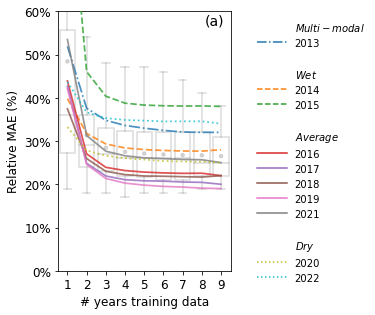

In [67]:
# create and save figure
pal = 'tab10'
col_pal = sns.color_palette(pal,
                            n_colors=len(df_results_yrs_orig.yr_test.unique()))
fig = plt.figure(figsize=(full_pg * 0.7, full_pg * 0.6))
ax1 = fig.add_subplot(1, 1, 1)
sns.boxplot(x='numb_yrs', y='mae_pct', color='grey', data=df_results_yrs_orig, ax=ax1,
            boxprops=dict(alpha=0.2, facecolor='white'), whiskerprops=dict(alpha=0.2), medianprops=dict(alpha=0.2),
            capprops=dict(alpha=0.2), flierprops=dict(alpha=0.2),
            showfliers=False, zorder=2)
yr_plt3 = sns.pointplot(x='numb_yrs', y='mae_pct',
                        data=df_results_yrs_orig, hue='yr_test', palette=col_pal,
                        hue_order=['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2021', '2020', '2022'],
                        ax=ax1, linestyles=list(lines_yrs_dict.values()), errorbar=None, estimator=np.mean)
plt.setp(yr_plt3.collections, sizes=[0])
plt.setp(yr_plt3.lines[-len(df_results_yrs_orig.yr_test.unique()):], linewidth=1.75,
         alpha=0.80)
avg_plt3 = sns.pointplot(x='numb_yrs', y='mae_pct', data=df_results_yrs_orig,
                         ax=ax1, color='grey', errorbar=None, linestyles='', scale=0.5)
plt.setp(avg_plt3.collections[-1], alpha=0.30)
plt.setp(avg_plt3.lines[-1], alpha=0.30)
ax1.set_ylim((0, 0.6))
ax1.set_xlabel('# years training data', fontsize=font_lg)
ax1.set_ylabel('Relative MAE (%)', fontsize=font_lg)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
ax1.tick_params(axis='both', which='major', labelsize=font_lg)
ax1.get_legend().remove()
ax1.text(x=0.85, y=0.95, s='(a)', transform=ax1.transAxes, size=font_xlg)

custom_lines = []
custom_lines.append(Line2D([0], [0], linestyle='', label="$\it{Multi-modal}$"))
col_i = 0
for yr in [2013]:
    custom_lines.append(Line2D([0], [0], color=col_pal[col_i], linestyle=lines_yrs_dict[yr],  linewidth=1.5,
                               label=str(yr)))
    col_i += 1
custom_lines.append(Line2D([0], [0], linestyle='', label=''))
custom_lines.append(Line2D([0], [0], linestyle='', label="$\it{Wet}$"))
for yr in [2014, 2015]:
    custom_lines.append(Line2D([0], [0], color=col_pal[col_i], linestyle=lines_yrs_dict[yr],  linewidth=1.5,
                               label=str(yr)))
    col_i += 1
custom_lines.append(Line2D([0], [0], linestyle='', label=''))
custom_lines.append(Line2D([0], [0], linestyle='', label="$\it{Average}$"))
for yr in [2016, 2017, 2018, 2019, 2021]:
    custom_lines.append(Line2D([0], [0], color=col_pal[col_i], linestyle=lines_yrs_dict[yr],  linewidth=1.5,
                               label=str(yr)))
    col_i += 1
custom_lines.append(Line2D([0], [0], linestyle='', label=''))
custom_lines.append(Line2D([0], [0], linestyle='', label="$\it{Dry}$"))
for yr in [2020, 2022]:
    custom_lines.append(Line2D([0], [0], color=col_pal[col_i], linestyle=lines_yrs_dict[yr],  linewidth=1.5,
                               label=str(yr)))
    col_i += 1
plt.figlegend(custom_lines, [l._label for l in custom_lines], ncol=1, fontsize=font_med,
              handlelength=3, loc='upper right', bbox_to_anchor=(1, 0.95), frameon=False)
fig.tight_layout(w_pad=1.0, rect=(0, 0, 0.65, 1))
if save_all_figs:
    #plt.savefig(outDIR_figs + '/Main/accuracy_by_numb_yrs_bootstrap.png', dpi=600, bbox_inches='tight', pad_inches=0.2)
    plt.savefig(os.path.join(outDIR_figs, 'accuracy_by_numb_yrs_bootstrap_orig.png'), dpi=300,
                bbox_inches='tight', pad_inches=0.2)
#plt.close()